# Risk Distribution Exploration

This notebook explores the beta-distributed risk assignment process described in the Healthcare AI Temporal Simulation Framework design document.

## Key Concepts

1. **Heterogeneous Patient Risk**: Real patient populations exhibit extreme risk heterogeneity
2. **Beta Distribution**: Used to create right-skewed risk distributions matching real-world patterns
3. **Population Calibration**: Scaling to ensure population mean equals target incident rate

## Learning Objectives

- Understand how beta distributions model realistic patient risk heterogeneity
- Visualize the impact of concentration parameters on risk distribution shape
- Validate that our approach maintains target population incident rates
- Compare beta distributions to alternative approaches

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Beta Distribution Basics

The beta distribution is parameterized by two shape parameters: α (alpha) and β (beta). For our healthcare simulation, we use a specific parameterization that creates a right-skewed distribution matching real-world risk patterns.

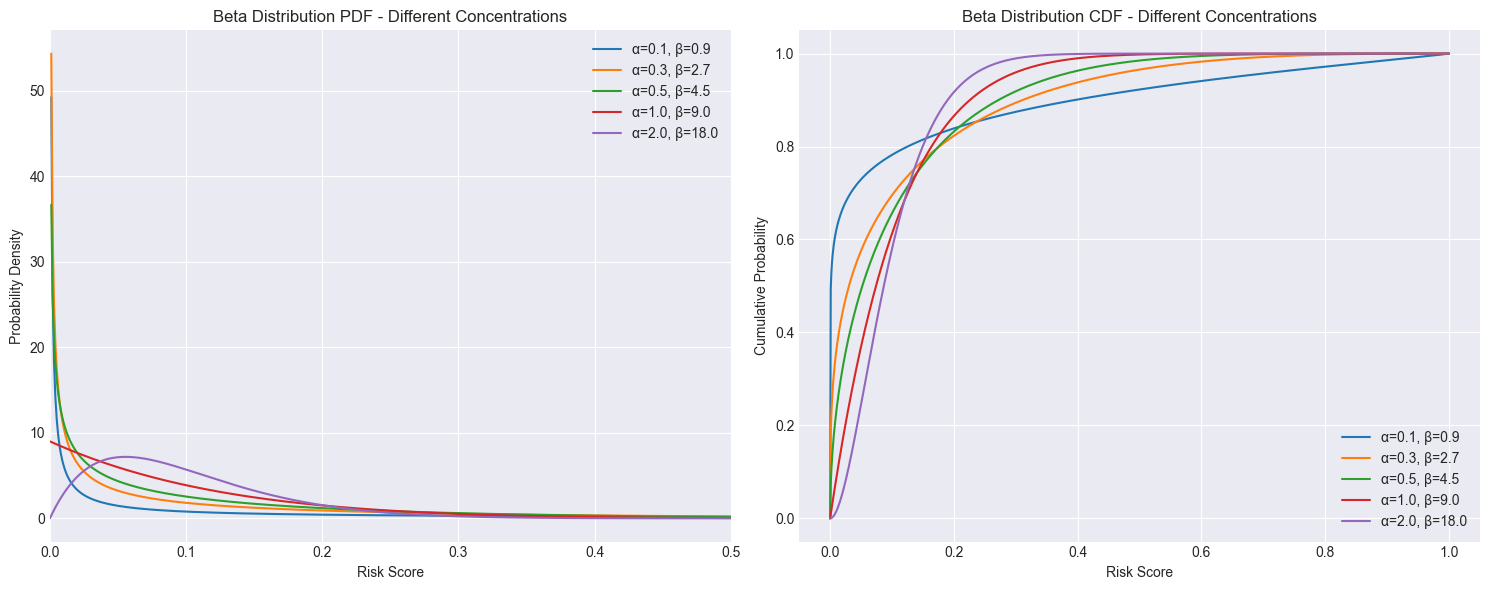

In [3]:
def plot_beta_distributions(concentrations=[0.1, 0.3, 0.5, 1.0, 2.0]):
    """Plot beta distributions with different concentration parameters."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    x = np.linspace(0, 1, 1000)
    
    for concentration in concentrations:
        # Using the parameterization from the design document
        # For a target annual incident rate of 0.1 (10%)
        annual_incident_rate = 0.1
        alpha = concentration
        beta_param = alpha * (1/annual_incident_rate - 1)
        
        # Plot PDF
        y = stats.beta.pdf(x, alpha, beta_param)
        ax1.plot(x, y, label=f'α={alpha:.1f}, β={beta_param:.1f}')
        
        # Plot CDF
        y_cdf = stats.beta.cdf(x, alpha, beta_param)
        ax2.plot(x, y_cdf, label=f'α={alpha:.1f}, β={beta_param:.1f}')
    
    ax1.set_xlabel('Risk Score')
    ax1.set_ylabel('Probability Density')
    ax1.set_title('Beta Distribution PDF - Different Concentrations')
    ax1.legend()
    ax1.set_xlim(0, 0.5)  # Focus on lower risk range where most patients are
    
    ax2.set_xlabel('Risk Score')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_title('Beta Distribution CDF - Different Concentrations')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_beta_distributions()

## 2. Risk Assignment Implementation

Now let's implement the exact risk assignment process from the design document and validate that it produces the correct population-level statistics.

In [4]:
def assign_patient_risks(n_patients, annual_incident_rate, concentration=0.5, random_seed=None):
    """
    Assign individual risk scores to patients using beta distribution.
    
    Parameters:
    -----------
    n_patients : int
        Number of patients to simulate
    annual_incident_rate : float
        Target population annual incident rate (e.g., 0.1 for 10%)
    concentration : float
        Beta distribution concentration parameter (lower = more heterogeneous)
    random_seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    base_annual_risks : np.ndarray
        Individual annual risk scores for each patient
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Distribution parameters for right-skewed shape
    alpha = concentration
    beta_param = alpha * (1/annual_incident_rate - 1)
    
    # Sample all patient risks at once
    raw_risks = np.random.beta(alpha, beta_param, n_patients)
    
    # Scale to ensure population mean equals target
    scaling_factor = annual_incident_rate / np.mean(raw_risks)
    base_annual_risks = np.clip(raw_risks * scaling_factor, 0, 0.99)
    
    return base_annual_risks

# Test the implementation
n_patients = 10000
target_rate = 0.1  # 10% annual incident rate

risks = assign_patient_risks(n_patients, target_rate, concentration=0.5, random_seed=42)

print(f"Number of patients: {n_patients:,}")
print(f"Target annual incident rate: {target_rate:.1%}")
print(f"\nActual population statistics:")
print(f"Mean risk: {np.mean(risks):.4f} (target: {target_rate:.4f})")
print(f"Median risk: {np.median(risks):.4f}")
print(f"Std dev: {np.std(risks):.4f}")
print(f"Min risk: {np.min(risks):.4f}")
print(f"Max risk: {np.max(risks):.4f}")
print(f"\nRisk percentiles:")
for p in [50, 75, 90, 95, 99]:
    print(f"  {p}th percentile: {np.percentile(risks, p):.4f}")

Number of patients: 10,000
Target annual incident rate: 10.0%

Actual population statistics:
Mean risk: 0.1000 (target: 0.1000)
Median risk: 0.0531
Std dev: 0.1213
Min risk: 0.0000
Max risk: 0.8739

Risk percentiles:
  50th percentile: 0.0531
  75th percentile: 0.1441
  90th percentile: 0.2678
  95th percentile: 0.3550
  99th percentile: 0.5380


## 3. Visualizing Risk Heterogeneity

Let's visualize how the risk is distributed across the population and demonstrate the extreme heterogeneity that matches real healthcare scenarios.

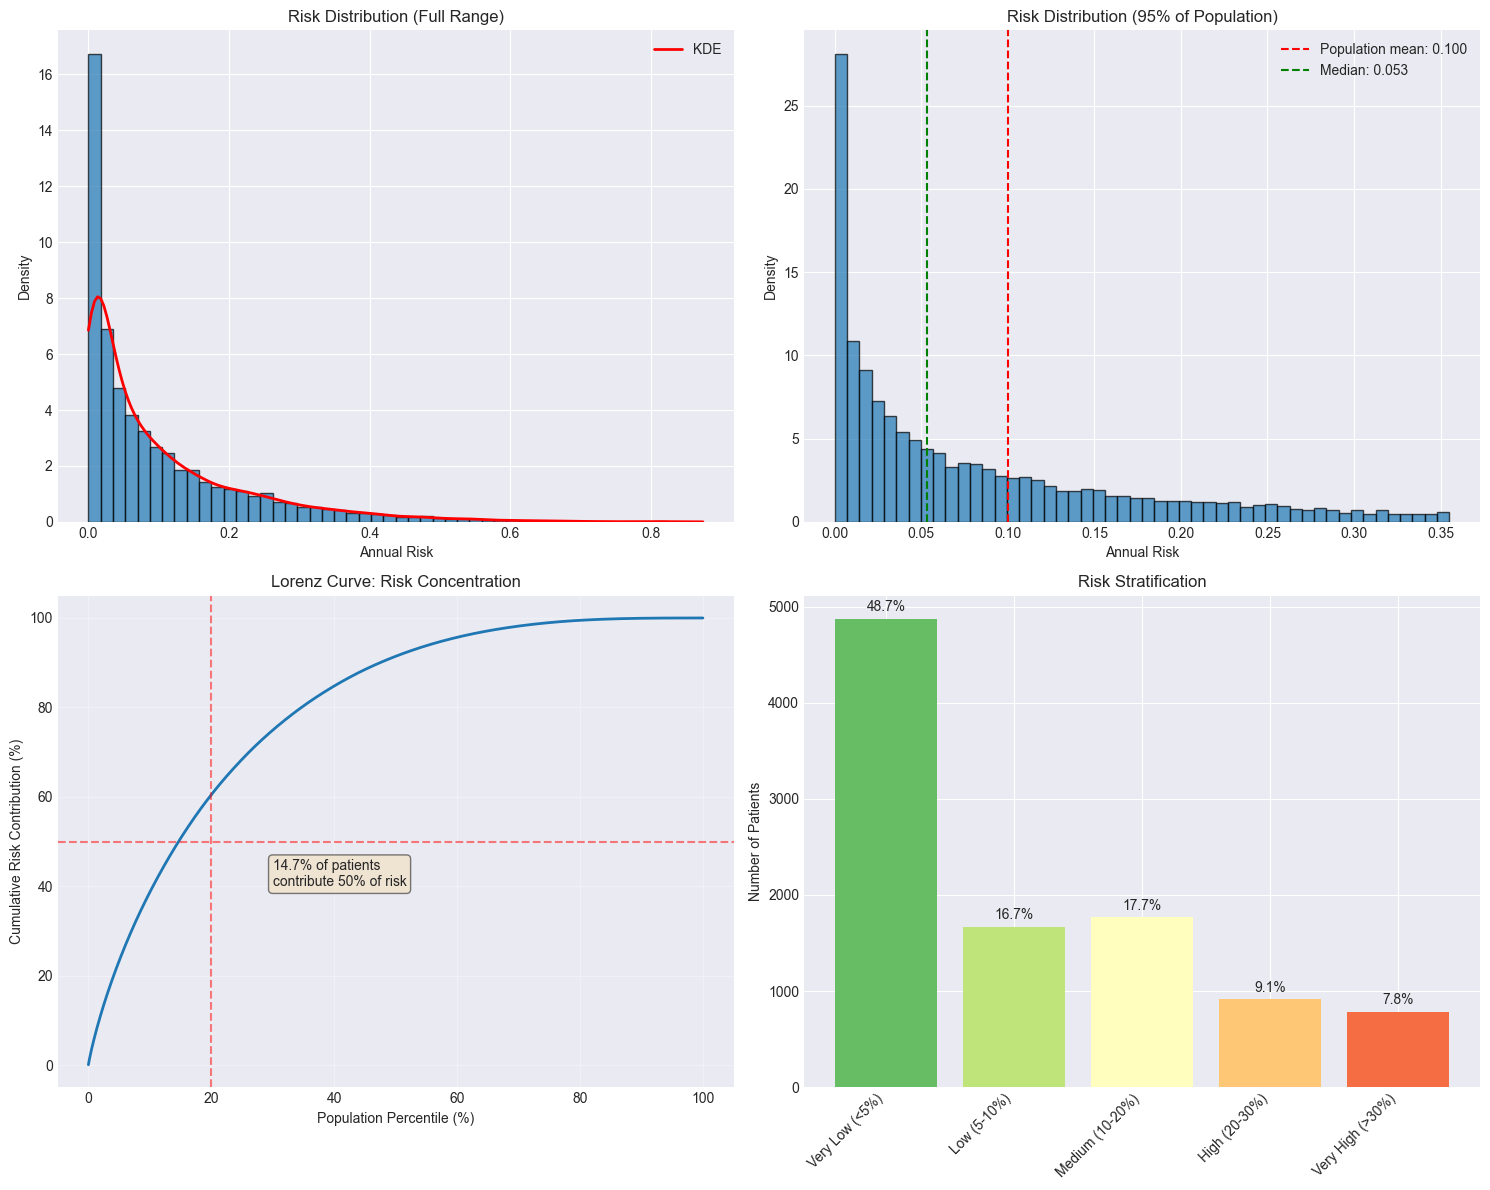

In [5]:
def visualize_risk_distribution(risks):
    """Create comprehensive visualization of risk distribution."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Histogram with KDE
    ax = axes[0, 0]
    ax.hist(risks, bins=50, alpha=0.7, density=True, edgecolor='black')
    
    # Add KDE
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(risks)
    x_range = np.linspace(0, risks.max(), 200)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    ax.set_xlabel('Annual Risk')
    ax.set_ylabel('Density')
    ax.set_title('Risk Distribution (Full Range)')
    ax.legend()
    
    # 2. Zoomed histogram (focus on lower risks)
    ax = axes[0, 1]
    low_risk_cutoff = np.percentile(risks, 95)
    low_risks = risks[risks <= low_risk_cutoff]
    ax.hist(low_risks, bins=50, alpha=0.7, density=True, edgecolor='black')
    ax.axvline(np.mean(risks), color='red', linestyle='--', label=f'Population mean: {np.mean(risks):.3f}')
    ax.axvline(np.median(risks), color='green', linestyle='--', label=f'Median: {np.median(risks):.3f}')
    ax.set_xlabel('Annual Risk')
    ax.set_ylabel('Density')
    ax.set_title('Risk Distribution (95% of Population)')
    ax.legend()
    
    # 3. Cumulative risk contribution
    ax = axes[1, 0]
    sorted_risks = np.sort(risks)[::-1]
    cumulative_risk = np.cumsum(sorted_risks) / np.sum(sorted_risks)
    population_fraction = np.arange(1, len(risks) + 1) / len(risks)
    
    ax.plot(population_fraction * 100, cumulative_risk * 100, linewidth=2)
    ax.axhline(50, color='red', linestyle='--', alpha=0.5)
    ax.axvline(20, color='red', linestyle='--', alpha=0.5)
    
    # Find what % of population contributes 50% of risk
    idx_50 = np.argmax(cumulative_risk >= 0.5)
    pct_50 = (idx_50 + 1) / len(risks) * 100
    ax.text(30, 40, f'{pct_50:.1f}% of patients\ncontribute 50% of risk', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Population Percentile (%)')
    ax.set_ylabel('Cumulative Risk Contribution (%)')
    ax.set_title('Lorenz Curve: Risk Concentration')
    ax.grid(True, alpha=0.3)
    
    # 4. Risk stratification
    ax = axes[1, 1]
    risk_categories = pd.cut(risks, 
                           bins=[0, 0.05, 0.1, 0.2, 0.3, 1.0],
                           labels=['Very Low (<5%)', 'Low (5-10%)', 
                                  'Medium (10-20%)', 'High (20-30%)', 
                                  'Very High (>30%)'])
    
    category_counts = risk_categories.value_counts()
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(category_counts)))
    
    bars = ax.bar(range(len(category_counts)), category_counts.values, color=colors)
    ax.set_xticks(range(len(category_counts)))
    ax.set_xticklabels(category_counts.index, rotation=45, ha='right')
    ax.set_ylabel('Number of Patients')
    ax.set_title('Risk Stratification')
    
    # Add percentage labels on bars
    for i, (bar, count) in enumerate(zip(bars, category_counts.values)):
        pct = count / len(risks) * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{pct:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

visualize_risk_distribution(risks)

## 4. Impact of Concentration Parameter

The concentration parameter controls how heterogeneous the risk distribution is. Lower values create more extreme heterogeneity.

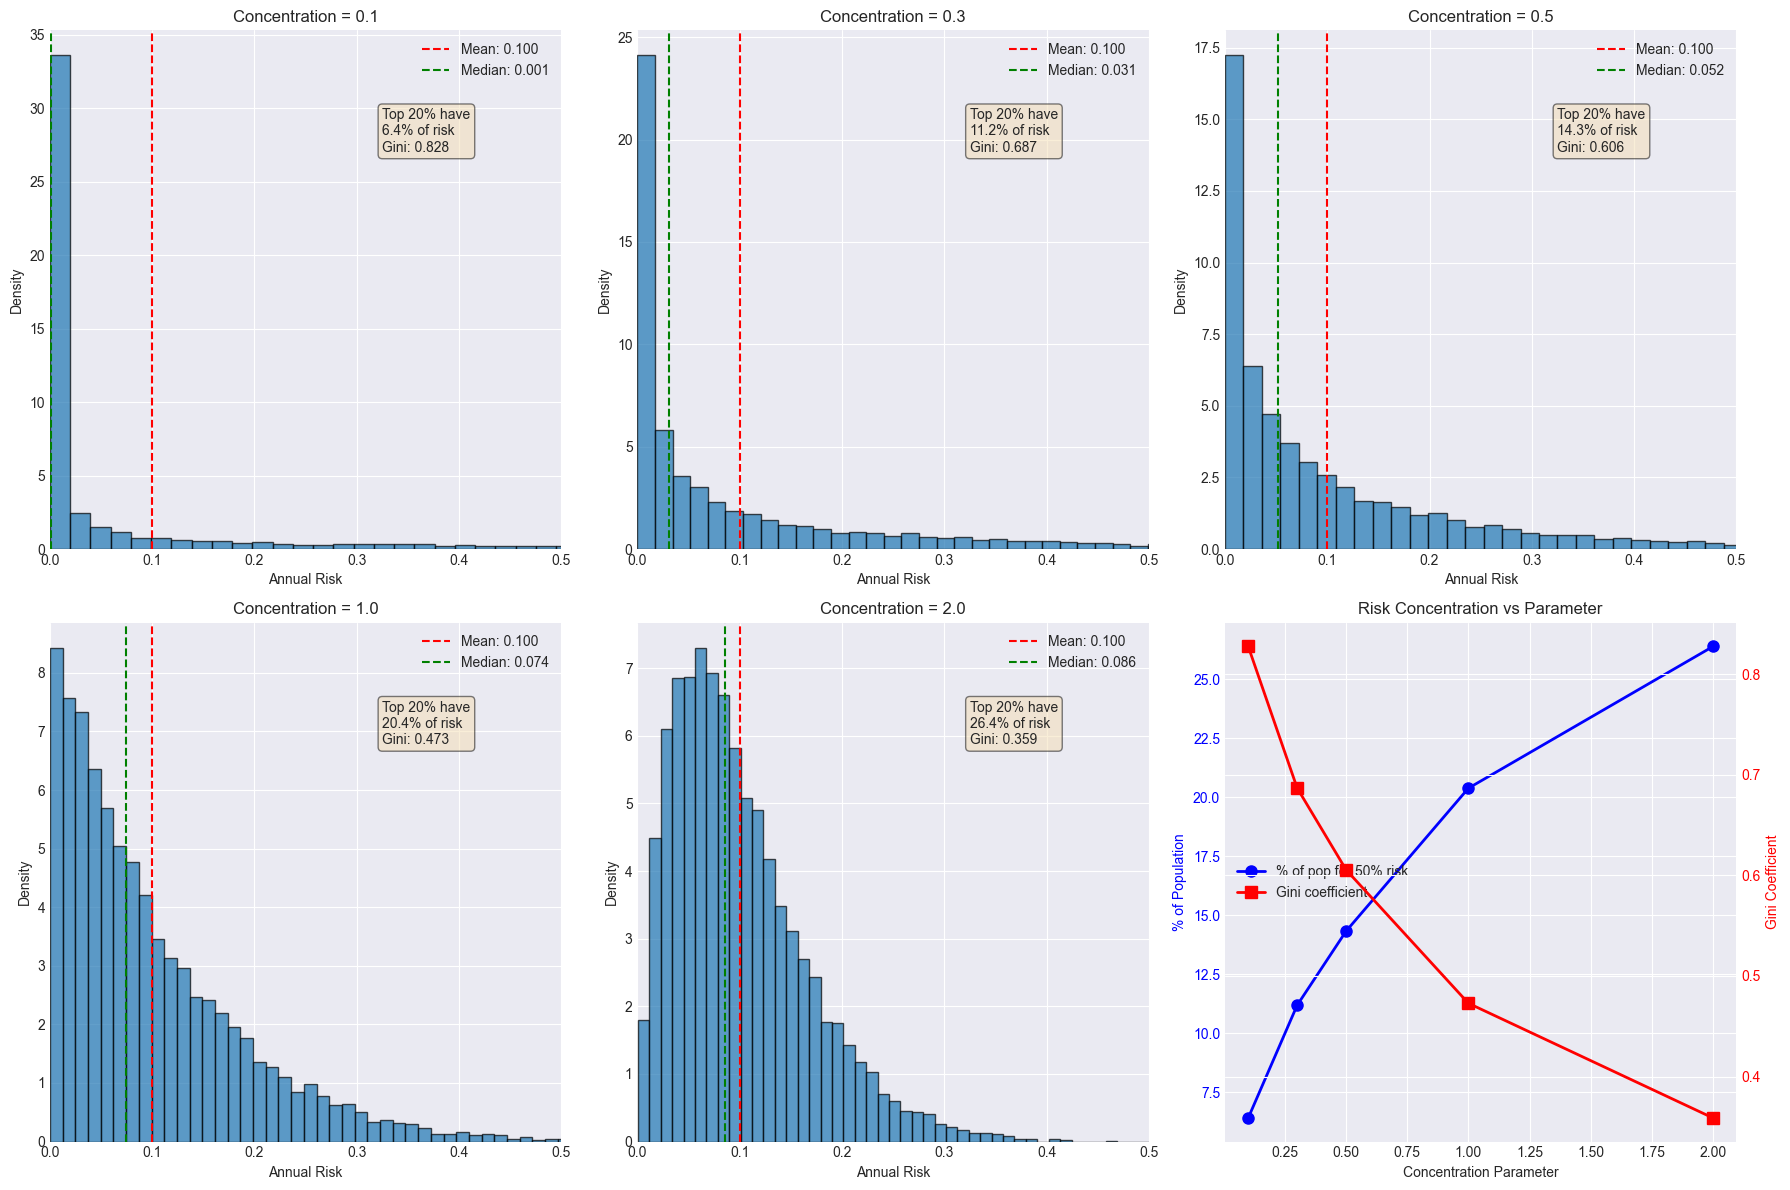


Summary Statistics by Concentration Parameter:
   concentration  mean  median     std     p95     p99  pct_for_50_risk  \
0            0.1   0.1  0.0011  0.2125  0.6533  0.9402             6.40   
1            0.3   0.1  0.0308  0.1477  0.4305  0.6531            11.18   
2            0.5   0.1  0.0516  0.1231  0.3674  0.5348            14.32   
3            1.0   0.1  0.0741  0.0904  0.2820  0.4051            20.38   
4            2.0   0.1  0.0858  0.0662  0.2282  0.3074            26.39   

     gini  
0  0.8277  
1  0.6869  
2  0.6056  
3  0.4728  
4  0.3587  


In [6]:
def compare_concentration_parameters():
    """Compare different concentration parameters and their effects."""
    concentrations = [0.1, 0.3, 0.5, 1.0, 2.0]
    n_patients = 10000
    target_rate = 0.1
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    results = []
    
    for i, concentration in enumerate(concentrations):
        # Generate risks
        risks = assign_patient_risks(n_patients, target_rate, concentration, random_seed=42+i)
        
        # Calculate statistics
        sorted_risks = np.sort(risks)[::-1]
        cumulative_risk = np.cumsum(sorted_risks) / np.sum(sorted_risks)
        idx_50 = np.argmax(cumulative_risk >= 0.5)
        pct_50 = (idx_50 + 1) / len(risks) * 100
        
        # Store results
        results.append({
            'concentration': concentration,
            'mean': np.mean(risks),
            'median': np.median(risks),
            'std': np.std(risks),
            'p95': np.percentile(risks, 95),
            'p99': np.percentile(risks, 99),
            'pct_for_50_risk': pct_50,
            'gini': np.sum(np.abs(sorted_risks[:, None] - sorted_risks)) / (2 * n_patients * np.sum(sorted_risks))
        })
        
        # Plot histogram
        ax = axes[i]
        ax.hist(risks, bins=50, alpha=0.7, density=True, edgecolor='black')
        ax.axvline(np.mean(risks), color='red', linestyle='--', label=f'Mean: {np.mean(risks):.3f}')
        ax.axvline(np.median(risks), color='green', linestyle='--', label=f'Median: {np.median(risks):.3f}')
        ax.set_xlabel('Annual Risk')
        ax.set_ylabel('Density')
        ax.set_title(f'Concentration = {concentration}')
        ax.set_xlim(0, 0.5)
        ax.legend()
        
        # Add text box with key stats
        textstr = f'Top 20% have\n{pct_50:.1f}% of risk\nGini: {results[-1]["gini"]:.3f}'
        ax.text(0.65, 0.85, textstr, transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                verticalalignment='top')
    
    # Summary plot
    ax = axes[-1]
    df_results = pd.DataFrame(results)
    
    ax2 = ax.twinx()
    
    line1 = ax.plot(df_results['concentration'], df_results['pct_for_50_risk'], 
                    'b-o', linewidth=2, markersize=8, label='% of pop for 50% risk')
    line2 = ax2.plot(df_results['concentration'], df_results['gini'], 
                     'r-s', linewidth=2, markersize=8, label='Gini coefficient')
    
    ax.set_xlabel('Concentration Parameter')
    ax.set_ylabel('% of Population', color='b')
    ax2.set_ylabel('Gini Coefficient', color='r')
    ax.set_title('Risk Concentration vs Parameter')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='center left')
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(results)

results_df = compare_concentration_parameters()
print("\nSummary Statistics by Concentration Parameter:")
print(results_df.round(4))

## 5. Validation: Population-Level Incident Generation

Let's validate that our risk assignment process correctly generates the expected number of incidents when simulated over time.

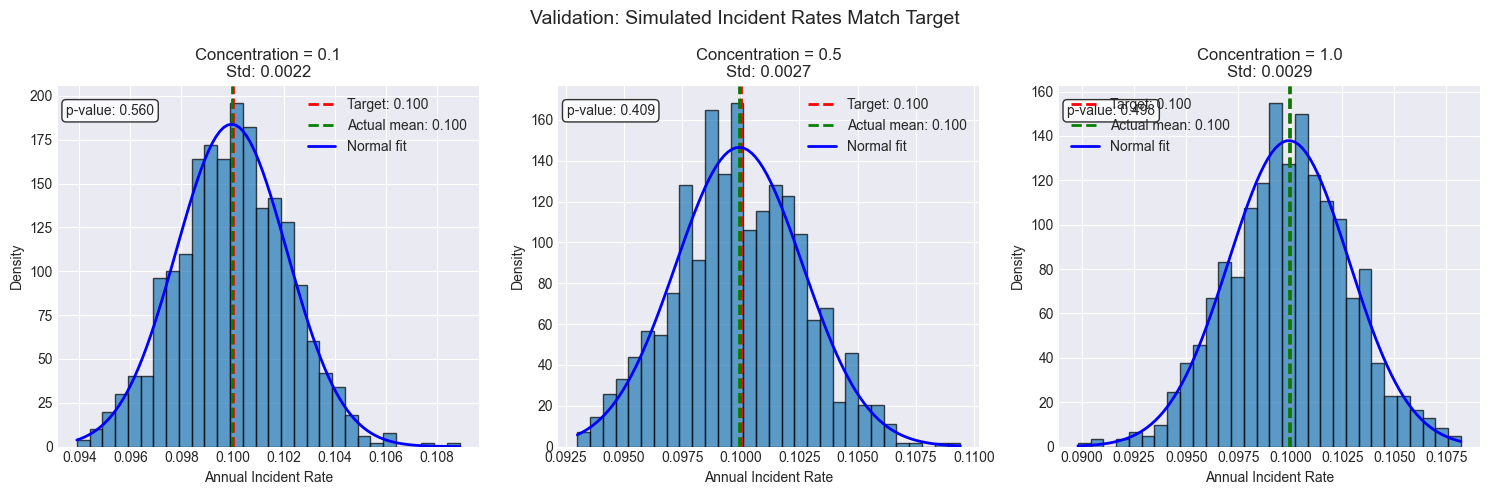

In [7]:
def simulate_annual_incidents(risks, n_simulations=100):
    """
    Simulate annual incidents based on individual risk scores.
    
    For each patient, their risk score represents their probability
    of having an incident in a given year.
    """
    n_patients = len(risks)
    incident_counts = []
    
    for sim in range(n_simulations):
        # For each patient, draw from Bernoulli distribution with p = risk
        incidents = np.random.binomial(1, risks)
        incident_counts.append(np.sum(incidents))
    
    return np.array(incident_counts)

# Run validation
n_patients = 10000
target_rate = 0.1
concentrations = [0.1, 0.5, 1.0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, concentration in enumerate(concentrations):
    risks = assign_patient_risks(n_patients, target_rate, concentration, random_seed=42)
    incident_counts = simulate_annual_incidents(risks, n_simulations=1000)
    incident_rates = incident_counts / n_patients
    
    ax = axes[i]
    ax.hist(incident_rates, bins=30, alpha=0.7, density=True, edgecolor='black')
    ax.axvline(target_rate, color='red', linestyle='--', linewidth=2, 
               label=f'Target: {target_rate:.3f}')
    ax.axvline(np.mean(incident_rates), color='green', linestyle='--', linewidth=2,
               label=f'Actual mean: {np.mean(incident_rates):.3f}')
    
    # Add normal distribution overlay
    from scipy import stats
    x = np.linspace(incident_rates.min(), incident_rates.max(), 100)
    ax.plot(x, stats.norm.pdf(x, np.mean(incident_rates), np.std(incident_rates)), 
            'b-', linewidth=2, label='Normal fit')
    
    ax.set_xlabel('Annual Incident Rate')
    ax.set_ylabel('Density')
    ax.set_title(f'Concentration = {concentration}\nStd: {np.std(incident_rates):.4f}')
    ax.legend()
    
    # Statistical test
    t_stat, p_value = stats.ttest_1samp(incident_rates, target_rate)
    ax.text(0.02, 0.95, f'p-value: {p_value:.3f}', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top')

plt.suptitle('Validation: Simulated Incident Rates Match Target', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Comparison with Alternative Distributions

Let's compare the beta distribution approach with other common distributions to understand why beta is preferred for healthcare risk modeling.

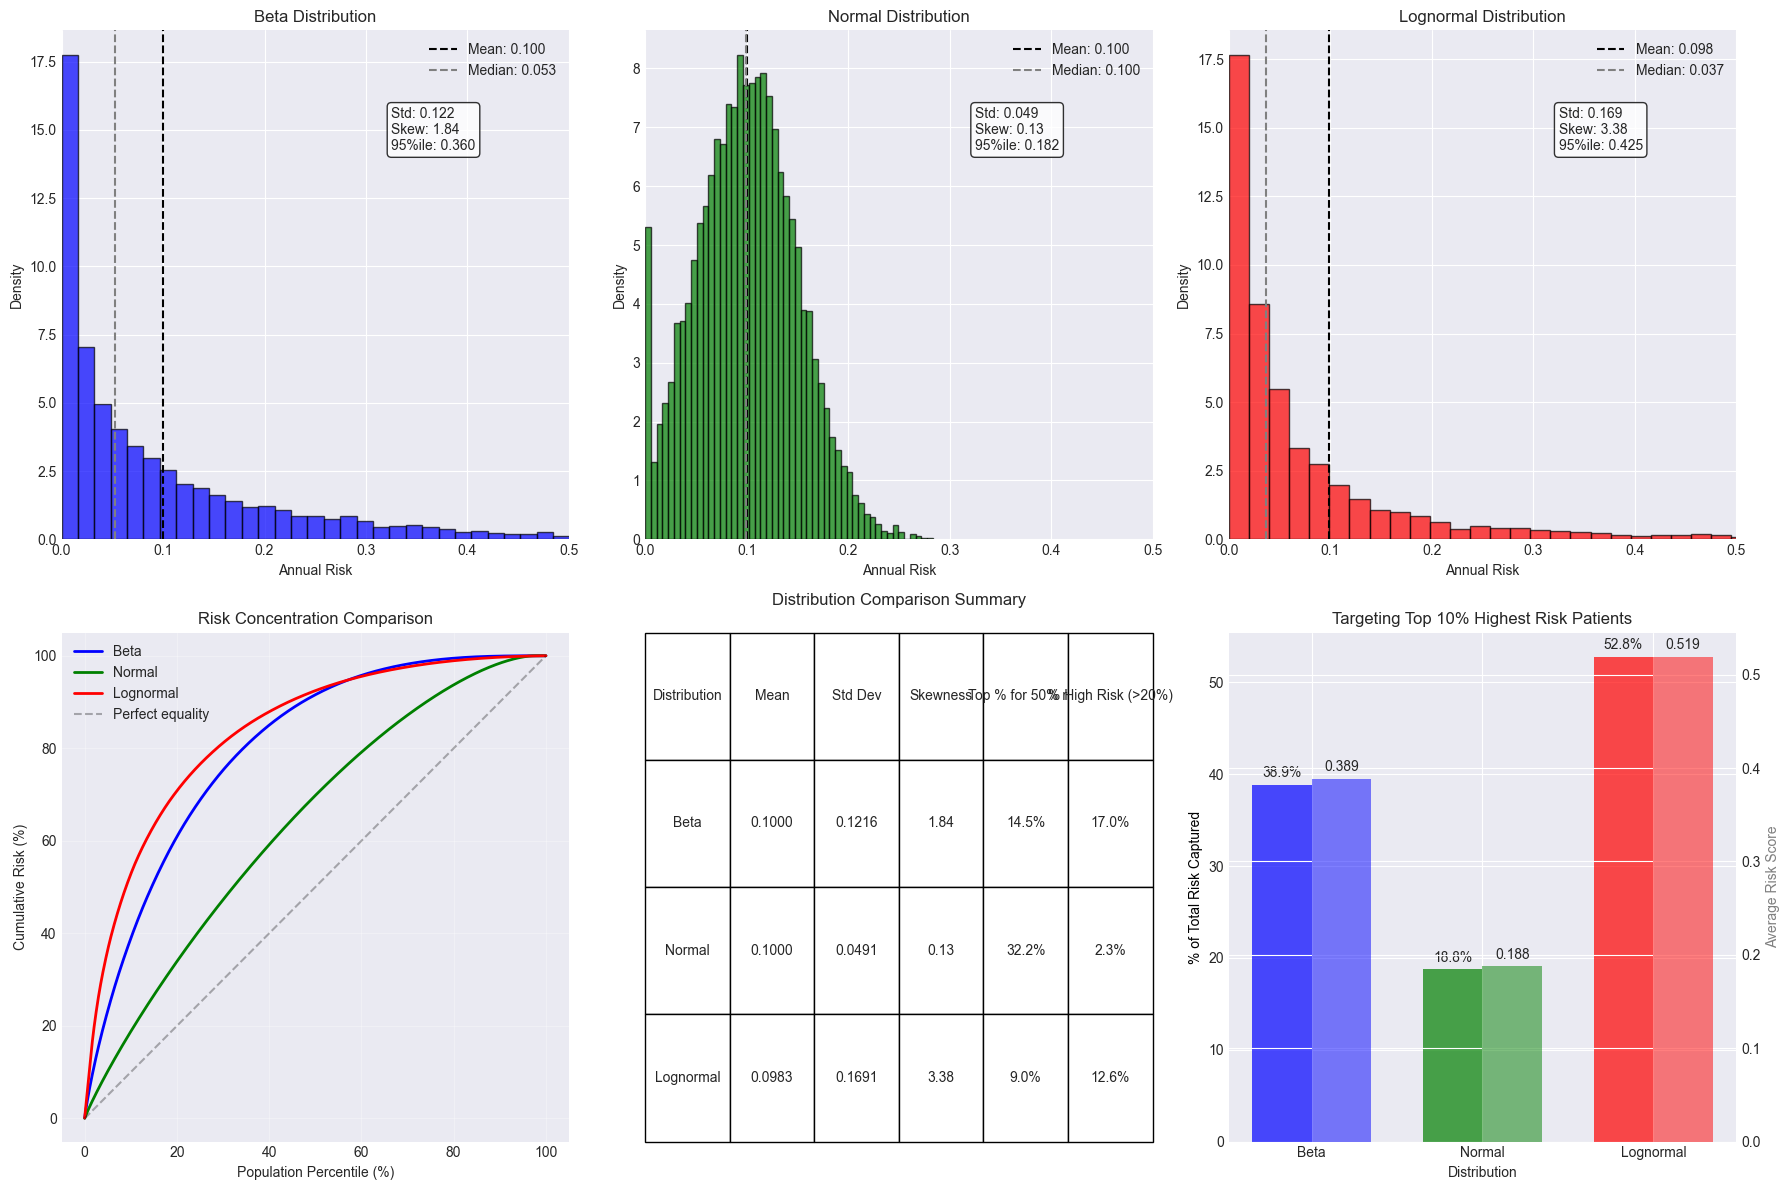

In [8]:
def compare_distributions(n_patients=10000, target_rate=0.1):
    """Compare beta distribution with normal and lognormal alternatives."""
    
    # Beta distribution (our approach)
    concentration = 0.5
    alpha = concentration
    beta_param = alpha * (1/target_rate - 1)
    beta_risks_raw = np.random.beta(alpha, beta_param, n_patients)
    scaling_factor = target_rate / np.mean(beta_risks_raw)
    beta_risks = np.clip(beta_risks_raw * scaling_factor, 0, 0.99)
    
    # Normal distribution (truncated)
    # Choose std to get some heterogeneity
    normal_std = target_rate * 0.5
    normal_risks = np.random.normal(target_rate, normal_std, n_patients)
    normal_risks = np.clip(normal_risks, 0, 1)
    # Rescale to match target mean
    normal_risks = normal_risks * (target_rate / np.mean(normal_risks))
    normal_risks = np.clip(normal_risks, 0, 0.99)
    
    # Lognormal distribution
    # Parameters chosen to roughly match target rate
    lognormal_sigma = 1.5
    lognormal_mu = np.log(target_rate) - lognormal_sigma**2 / 2
    lognormal_risks = np.random.lognormal(lognormal_mu, lognormal_sigma, n_patients)
    lognormal_risks = np.clip(lognormal_risks, 0, 1)
    # Rescale to match target mean
    lognormal_risks = lognormal_risks * (target_rate / np.mean(lognormal_risks))
    lognormal_risks = np.clip(lognormal_risks, 0, 0.99)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    distributions = [
        ('Beta', beta_risks, 'blue'),
        ('Normal', normal_risks, 'green'),
        ('Lognormal', lognormal_risks, 'red')
    ]
    
    # Row 1: Histograms
    for i, (name, risks, color) in enumerate(distributions):
        ax = axes[0, i]
        ax.hist(risks, bins=50, alpha=0.7, density=True, color=color, edgecolor='black')
        ax.axvline(np.mean(risks), color='black', linestyle='--', 
                   label=f'Mean: {np.mean(risks):.3f}')
        ax.axvline(np.median(risks), color='gray', linestyle='--',
                   label=f'Median: {np.median(risks):.3f}')
        ax.set_xlabel('Annual Risk')
        ax.set_ylabel('Density')
        ax.set_title(f'{name} Distribution')
        ax.set_xlim(0, 0.5)
        ax.legend()
        
        # Add statistics box
        stats_text = f'Std: {np.std(risks):.3f}\n'
        stats_text += f'Skew: {stats.skew(risks):.2f}\n'
        stats_text += f'95%ile: {np.percentile(risks, 95):.3f}'
        ax.text(0.65, 0.85, stats_text, transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
    
    # Row 2: Lorenz curves and summary comparison
    ax = axes[1, 0]
    for name, risks, color in distributions:
        sorted_risks = np.sort(risks)[::-1]
        cumulative_risk = np.cumsum(sorted_risks) / np.sum(sorted_risks)
        population_fraction = np.arange(1, len(risks) + 1) / len(risks)
        ax.plot(population_fraction * 100, cumulative_risk * 100, 
                linewidth=2, label=name, color=color)
    
    ax.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Perfect equality')
    ax.set_xlabel('Population Percentile (%)')
    ax.set_ylabel('Cumulative Risk (%)')
    ax.set_title('Risk Concentration Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Summary statistics table
    ax = axes[1, 1]
    ax.axis('off')
    
    summary_data = []
    for name, risks, _ in distributions:
        sorted_risks = np.sort(risks)[::-1]
        cumulative_risk = np.cumsum(sorted_risks) / np.sum(sorted_risks)
        idx_50 = np.argmax(cumulative_risk >= 0.5)
        pct_50 = (idx_50 + 1) / len(risks) * 100
        
        summary_data.append([
            name,
            f"{np.mean(risks):.4f}",
            f"{np.std(risks):.4f}",
            f"{stats.skew(risks):.2f}",
            f"{pct_50:.1f}%",
            f"{np.sum(risks > 0.2) / len(risks) * 100:.1f}%"
        ])
    
    table = ax.table(cellText=summary_data,
                     colLabels=['Distribution', 'Mean', 'Std Dev', 'Skewness', 
                               'Top % for 50% risk', '% High Risk (>20%)'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax.set_title('Distribution Comparison Summary', pad=20)
    
    # Realistic scenario test
    ax = axes[1, 2]
    
    # Simulate identifying top 10% highest risk patients
    threshold_percentile = 90
    
    results = []
    for name, risks, color in distributions:
        threshold = np.percentile(risks, threshold_percentile)
        high_risk_patients = risks >= threshold
        
        # What % of total risk do these patients represent?
        risk_captured = np.sum(risks[high_risk_patients]) / np.sum(risks) * 100
        
        # What's their average risk?
        avg_risk_high = np.mean(risks[high_risk_patients])
        
        results.append({
            'name': name,
            'risk_captured': risk_captured,
            'avg_risk': avg_risk_high,
            'color': color
        })
    
    x = np.arange(len(results))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, [r['risk_captured'] for r in results], width,
                    label='% of Total Risk', color=[r['color'] for r in results], alpha=0.7)
    
    ax2 = ax.twinx()
    bars2 = ax2.bar(x + width/2, [r['avg_risk'] for r in results], width,
                     label='Avg Risk Score', color=[r['color'] for r in results], alpha=0.5)
    
    ax.set_xlabel('Distribution')
    ax.set_ylabel('% of Total Risk Captured', color='black')
    ax2.set_ylabel('Average Risk Score', color='gray')
    ax.set_title(f'Targeting Top 10% Highest Risk Patients')
    ax.set_xticks(x)
    ax.set_xticklabels([r['name'] for r in results])
    
    # Add value labels on bars
    for bar1, bar2, result in zip(bars1, bars2, results):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.5,
                f'{height1:.1f}%', ha='center', va='bottom')
        ax2.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.005,
                 f'{height2:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

compare_distributions()

## 7. Key Insights and Implications

### Why Beta Distribution?

1. **Natural Bounds**: Risk scores are naturally bounded [0, 1], which beta handles natively
2. **Flexible Shape**: The concentration parameter allows us to model different levels of population heterogeneity
3. **Right Skew**: Matches real healthcare data where most patients are low risk
4. **Mathematical Properties**: Easy to parameterize to achieve exact population mean

### Practical Implications

1. **Resource Concentration**: ~20% of patients typically account for 50-80% of risk
2. **Intervention Targeting**: High-risk patients offer the greatest opportunity for impact
3. **Model Requirements**: ML models must handle extreme class imbalance
4. **Realistic Evaluation**: Simulations must capture this heterogeneity for valid conclusions

### Next Steps

This risk distribution forms the foundation for:
- Temporal risk evolution (AR(1) process)
- Hazard-based incident generation
- Intervention effect modeling
- ML model simulation

In [9]:
# Save key functions for use in other notebooks
import pickle

risk_functions = {
    'assign_patient_risks': assign_patient_risks,
    'simulate_annual_incidents': simulate_annual_incidents
}

with open('risk_distribution_functions.pkl', 'wb') as f:
    pickle.dump(risk_functions, f)

print("Risk distribution functions saved for future use.")

Risk distribution functions saved for future use.
